In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from desiutil.log import get_logger, DEBUG
from desidiff.src.group_tiles import *
from desidiff.src.dates_to_process import *
from desidiff.src.coadd import *

In [4]:
yyyymmdd=20210606
tile_petal,group_tid,group_tp, group_night =getMatchedTileid(yyyymmdd)

INFO:spectra.py:282:read_spectra: iotime 1.481 sec to read spectra-8-1882-thru20210606.fits at 2021-08-31T14:38:15.607246
[39632967181535819] ((1882, 8),)


/global/cscratch1/sd/akim/project/timedomain/desidiff/src/coadd.py:21: RuntimeWarning: invalid value encountered in true_divide
  sflux[b] = sflux[b]/sivar[b]


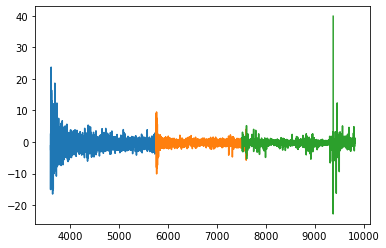

In [ ]:
plt.ion()
date = yyyymmdd
# tile_petal contain subsets of tile/petals whose RA/DEC targets are not contained in other tile/petals from that night
for tps in tile_petal:
    # Check to see if this tile/petal has nothing to subtract.  Skip's IO if this is the case
    # loop over all unique RA/DEC pairs from that night
    hasNothing=True
    for tid, tp, night in zip(group_tid,group_tp,group_night):
        # if this RA/DEC is not in thie tile_petal combination than skip
        if tp[0] not in tps:
            continue
        if len(night) > 1:
            hasNothing=False
    if hasNothing:
        continue
    
    # cache spectra to minimize IO
    spectra_list=dict()
    target_list=[]
    for tp in tps:
        filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{tp[0]}/{yyyymmdd}/spectra-{tp[1]}-{tp[0]}-thru{yyyymmdd}.fits"
        spectra_list[(tp[0],tp[1])]=read_spectra(filename)
    
    newSpectra=[]
    refSpectra=[]
    # loop over all unique RA/DEC pairs from that night
    for tid, tp, night in zip(group_tid,group_tp,group_night):
        # if this RA/DEC is not in thie tile_petal combination than skip
        if tp[0] not in tps:
            continue
            
        if len(night) == 1:
            continue
            
        # Eliminate those with no reference night here
        # Proceed with a subtraction for this object
        
        # The coadds of the new and reference are constructed from all spectra with all targetid's in tid and all
        # tile/petal combinations in tp, which are cached above
        print(tid, tp)
        
        for tile,plate in tp:
            spec = spectra_list[(tile,plate)]
            
            idx = numpy.in1d(night, date)
            ref_night = night[~idx]
            
            newSpectra.append(spec.select(nights=date, targets = tid))
            
            """
            There is a variable night that has all the nights associated with this RA/DEC
            derive the ref_night from that
            """
            
            refSpectra.append(spec.select(nights=ref_night, targets = tid))
            
        
        newflux, newivar, newwave, newmask = coadd(newSpectra)
        refflux, refivar, refwave, refmask = coadd(refSpectra)
       
        difflux, difivar, difmask, reflam = dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"]), dict.fromkeys(["b", "r", "z"])
        
        difflux = {key: newflux[key] - refflux.get(key, 0)
                       for key in newflux.keys()}
        difivar = {key: newivar[key] - refivar.get(key, 0)
                       for key in newivar.keys()}
        difmask = {key: numpy.logical_and(newmask[key], refmask.get(key, 0))
                       for key in newmask.keys()}
        """
        assignment to a differenced Spectra object 
        """
        
        for b in difflux.keys():
            plt.plot(newwave[b],difflux[b][0,:])
            
        display.display(plt.gcf())
        display.clear_output(wait=True)
        try:
            x=input("Type 'E' to exit")
        except KeyboardInterrupt:
            break
        if x=="E":
            break
    else:
        continue

    break

In [54]:
spectra_list

{(1239, 6): <desispec.spectra.Spectra at 0x2aaae3a12250>}

In [3]:
night_arr = getUnprocessedDates()
print(night_arr)

len(night_arr): 20
--- get unprocessed dates took:  58.364365100860596 seconds ---
[20210606 20210607 20210614 20210615 20210616 20210617 20210618 20210619
 20210620 20210621 20210626 20210627 20210628 20210629 20210704 20210705
 20210706 20210707 20210708 20210709]


In [ ]:
### for debugging purposes remove 'for a in night_arr:'-loop, assign yyyymmdd = 20210606 or 20210406 for example


for a in night_arr:   
    # read in and store in one place all the fibermap information in the spectra files
    yyyymmdd = a
    dats=[]
    for filename in glob.glob(f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/*/{yyyymmdd}/spectra-*.fits"):
        t = Table.read(filename, format='fits',hdu=1, memmap=True)[['TARGETID','TARGET_RA','TARGET_DEC','TILEID','OBJTYPE','PETAL_LOC', 'NIGHT']]
        t=t[t['OBJTYPE']=='TGT']
        dats.append(t)
    dats=vstack(dats, join_type='inner',metadata_conflicts='silent')
    # group all the observations by TARGET_RA and TARGET_DEC
    # note that this is more reliable than grouping by TARGETID as TARGETID is NOT a unique identifier of RA and DEC
    dats_group = dats.group_by(['TARGET_RA','TARGET_DEC'])
    
    # for each group make a tuple containing all tileid/petal combinations that have that ra/dec
    tile_petal=[]
    # for each group, determine the unique nights that occur
    night=[]
    for g in dats_group.groups:
        
        gu = unique(g, keys=['TILEID'])
        
        dum=[]
        for a,b,c in zip(gu['TILEID'],gu['PETAL_LOC'],gu['TARGETID']):
            dum.append((a,b,c))
        tile_petal.append(tuple(dum))


        du = unique(g, keys=['NIGHT'])
        
        for d in zip(du['NIGHT']):
            night.append((d))
        

    # compress things down to the unique tile/petal combinations
    tile_petal = list(set(tile_petal))
    # union sets that have intersecting tile/petal combinations
    for i in range(len(tile_petal)-1,0,-1):
        for j in range(i-1,-1,-1):
            if len(set(tile_petal[i]) & set(tile_petal[j])) !=0:
                tile_petal[j]=tile_petal[i]+tile_petal[j]
                del tile_petal[i]
                break
    # unique of each set
    for i in range(len(tile_petal)):
        tile_petal[i]=list(set(tile_petal[i]))
    
    unique_night = numpy.unique(night)
    
    for i in tile_petal:
        spectra = Spectra()
        dif_spectra = Spectra()
        ref_spectra = Spectra() ### or else NameError at 'if ref_spectra.num_spectra'... in the case of no reference nights
        for j in i:    ### covers case of multiple tile/petal pairs 
            filename =  f"/global/project/projectdirs/desi/spectro/redux/daily/tiles/cumulative/{j[0]}/{yyyymmdd}/spectra-{j[1]}-{j[0]}-thru{yyyymmdd}.fits"
            spectra = read_spectra(filename)
            date = numpy.array(yyyymmdd)
            idx = numpy.in1d(unique_night, date)
            ref_night = unique_night[~idx]

            try:
                cur_spectra = (spectra.select(nights=date, targets = [j[2]]))
                ref_spectra = (spectra.select(nights=ref_night, targets = [j[2]]))
            except:
                pass ### this is the mechanism for eliminating targets that have no reference nights. 

            if ref_spectra.num_spectra() != 0:
            ### in the case of no ref nights, as 'pass' has allowed a reference spectra to be created despite a RuntimeError, this is the check that there is something to difference
                coadd(ref_spectra)
                dif_spectra.update(cur_spectra)
                coadd(dif_spectra)
                for b in dif_spectra.bands:
                    dif_spectra.flux[b][0] = cur_spectra.flux[b][0]-ref_spectra.flux[b][0]
                    ok = numpy.logical_and(dif_spectra.mask[b][0,:] == 0, dif_spectra.ivar[b][0] != 0)
                    plt.plot(cur_spectra.wave[b][ok], cur_spectra.flux[b][0,ok], color = 'red', label = "current spectra")
                    plt.plot(ref_spectra.wave[b][ok],ref_spectra.flux[b][0,ok], color = 'green', label = 'reference spectra')
                    plt.plot(dif_spectra.wave[b][ok],dif_spectra.flux[b][0,ok], color = 'cyan', label = 'differenced spectra')
                    if b == 'b':
                        plt.legend()
                plt.show()
                
                # save each days candidate plots into one pdf
                with PdfPages('diff_candidates(%d).pdf' % yyyymmdd) as pdf:
                    fig = plt.figure()
                    pdf.savefig(fig)

    ### insert garbage collection potentially
            
    
    